This tutorial demostrates Pointer Networks with readable code.

In [38]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA = False

In [39]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Generating dataset for sorting task</h3>

In [40]:
class SortDataset(Dataset):
    
    def __init__(self, data_len, num_samples, random_seed=111):
        super(SortDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for _ in tqdm(range(num_samples)):
            x = x = torch.randperm(data_len)
            # x = x = torch.ones(data_len, dtype=torch.int64) # a modification to understand embedding and encoder
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

In [41]:
train_size = 1000
val_size = 100

In [42]:
train_dataset = SortDataset(10, train_size)
val_dataset   = SortDataset(10, val_size)

100%|██████████| 100/100 [00:00<00:00, 99864.38it/s]


In [43]:
j = 0
for i in train_dataset:
    print(i)
    j += 1
    if j == 5:
        break

tensor([0, 2, 6, 1, 8, 7, 5, 4, 3, 9])
tensor([4, 1, 9, 5, 2, 0, 8, 6, 7, 3])
tensor([6, 1, 8, 7, 9, 0, 5, 2, 3, 4])
tensor([6, 4, 0, 7, 5, 1, 9, 2, 8, 3])
tensor([5, 7, 0, 6, 4, 3, 1, 8, 9, 2])


<h3>Attention mechanism</h3>
<p>
Using two types of attention mechanism: "Dot" and "Bahdanau" . More details in <a href="http://aclweb.org/anthology/D15-1166">Effective Approaches to Attention-based Neural Machine Translation</a></p>

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & Dot \\
v_a ^\top \tanh(\textbf{W}_a [ h_t ; \bar h_s ]) & Bahdanau
\end{cases}
$$

In [44]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.C = C
        
        V = torch.FloatTensor(hidden_size)
        if use_cuda:
            V = V.cuda()  
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)

        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
        ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len] 

        expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]

        logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

<h3>Pointer Network</h3>
<p><a href="https://arxiv.org/abs/1506.03134">Pointer Networks
</a></p>
<p>The model solves the problem of variable size output dictionaries using a recently proposed mechanism of neural attention. It differs from the previous attention attempts in that, instead of using attention to blend hidden units of an encoder to a context vector at each decoder step, it uses attention as a pointer to select a member of the input sequence as the output.</p>
<img src="./imgs/Снимок экрана 2017-12-26 в 4.30.58 ДП.png">

In [45]:
class PointerNet(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        for i in range(seq_len):
            
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            decoder_input = target_embedded[:,i,:]
            
            loss += self.criterion(logits, target[:,i])
            
            
        return loss / seq_len

In [46]:
pointer = PointerNet(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)
adam = optim.Adam(pointer.parameters(), lr=1e-4)

if USE_CUDA:
    pointer = pointer.cuda()

In [47]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=True)

<h3>The data</h3>

In [48]:
for sample_batch in train_loader:
    inputs = Variable(sample_batch)
    print(inputs)
    print(sample_batch)
    print(torch.equal(sample_batch, inputs)) # True
    target = Variable(torch.sort(sample_batch)[0])
    print(torch.sort(sample_batch)) # returns: torch.return_types.sort( values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), indices=tensor([[5, 0, 9, 2, 3, 1, 8, 4, 7, 6]]) )
    print(target) # sorted data
    break

tensor([[5, 3, 4, 9, 8, 2, 6, 7, 1, 0],
        [7, 0, 1, 9, 4, 6, 8, 3, 5, 2]])
tensor([[5, 3, 4, 9, 8, 2, 6, 7, 1, 0],
        [7, 0, 1, 9, 4, 6, 8, 3, 5, 2]])
True
torch.return_types.sort(
values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
indices=tensor([[9, 8, 5, 1, 2, 0, 6, 7, 4, 3],
        [1, 2, 9, 7, 4, 8, 5, 0, 6, 3]]))
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


<h3>The data returned in a forward step</h3>

In [49]:
for sample_batch in train_loader:
    inputs = sample_batch
    target = torch.sort(sample_batch)[0]
    loss = pointer(inputs, target)
    print(loss) # loss of batch, returned: tensor(2.2132, grad_fn=<DivBackward0>)
    break

tensor(1.8661, grad_fn=<DivBackward0>)


C:\Users\Felipe\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Felipe\AppData\Local\Temp\ipykernel_2480\621501415.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [50]:
# example lstm run:
input = torch.tensor([
  [[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]],
  [[0.13, 0.14], [0.15, 0.16], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]
])
print(input.shape)
rnn = nn.LSTM(2, 2, batch_first=True)
h0 = torch.randn(1, 2, 2)
c0 = torch.randn(1, 2, 2)
output, (hn, cn) = rnn(input, (h0, c0))
print('output:')
print(output)
print('hidden state output - ', hn)
print('hidden.squeeze(0) -', hn.squeeze(0))
print('cell state output - ', cn)

torch.Size([2, 10, 2])
output:
tensor([[[-0.2669, -0.2705],
         [-0.3211, -0.1551],
         [-0.3399, -0.1390],
         [-0.3461, -0.1273],
         [-0.3485, -0.1197],
         [-0.3497, -0.1144],
         [-0.3500, -0.1109],
         [-0.3502, -0.1088],
         [-0.3503, -0.1076],
         [-0.3503, -0.1069]],

        [[-0.5047,  0.1935],
         [-0.4515,  0.0299],
         [-0.3863, -0.0277],
         [-0.3622, -0.0622],
         [-0.3543, -0.0818],
         [-0.3520, -0.0924],
         [-0.3511, -0.0981],
         [-0.3507, -0.1014],
         [-0.3505, -0.1033],
         [-0.3504, -0.1044]]], grad_fn=<TransposeBackward0>)
hidden state output -  tensor([[[-0.3503, -0.1069],
         [-0.3504, -0.1044]]], grad_fn=<StackBackward0>)
hidden.squeeze(0) - tensor([[-0.3503, -0.1069],
        [-0.3504, -0.1044]], grad_fn=<SqueezeBackward1>)
cell state output -  tensor([[[-0.6242, -0.2198],
         [-0.6244, -0.2144]]], grad_fn=<StackBackward0>)


<h3>What a forwad step does:</h3>


<img src='./.github/lstmcell.png' width='500px'>

<small>Image by The A.I. Hacker - Michael Phi - https://www.youtube.com/watch?v=8HyCNIVRbSU</small>

<p>blue activation is tanh, red is sigmoid</p>
<p>X is pointwise multiplication, + is pointwise addition</p>

In [51]:
seq_len = 10
embedding_size = 2
hidden_size = 2

batch_size = 2

embedding = nn.Embedding(seq_len, embedding_size)
encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)

n_glimpses = 1
tanh_exploration=10 # 10 or seq len, because seq_len is 10
glimpse = Attention(hidden_size, use_tanh=False, use_cuda=False)
pointer_layer = Attention(hidden_size, use_tanh=True, C=tanh_exploration, use_cuda=False)

print('Outside loop of train_loader, decoder_start_input: ')
decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
print(decoder_start_input.shape)
print(decoder_start_input)
# I believe decoder_start_input got started with random parameters
decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
# then decoder_start_input only gets regulated, by using uniform_, 
# passing -1 * 1. / math.sqrt(embedding_size) and 1. / math.sqrt(embedding_size) as arguments
print(decoder_start_input.shape)
print(decoder_start_input)

Outside loop of train_loader, decoder_start_input: 
torch.Size([2])
Parameter containing:
tensor([2.0156, 0.0000], requires_grad=True)
torch.Size([2])
Parameter containing:
tensor([-0.4374,  0.3281], requires_grad=True)


In [52]:
# for sample_batch in train_loader:
it = iter(train_loader)
sample_batch = next(it)
print('train_loader loop started')
inputs = sample_batch
target = torch.sort(sample_batch)[0]
print('Input and target:')
print(inputs)
print(target)

batch_size = inputs.size(0) 
print('batch_size - ', batch_size) # returns 1, the batch_size example
seq_len = inputs.size(1)
print('seq_len - ', seq_len) # returns 10, the input number of entries/shape example, and ensures it's ten

embedded = embedding(inputs) # embedding take seq_len (10) and embedding_size (2) as arguments
print('embedded data:')
print(embedded.shape)
print(embedded) 
"""
in this cell example, the embedding_size is 2, thus shape will output [1, 10, 2]
embedding can be thought as a manner of representing data, for example:
for an array like [1, 2, 3], we could say that the numbers could be represented by a vector of dimension two,
and the '1' being the value "[0.5, 0.6]" for example, the others will be represented by a vector as well
turning into [[0.4, 0.5], [0,6, 0,7], [0,8, 0.9]], for example.
Embed means implant, i.e. implant [0.4, 0.5] in 1.

This can verifired passing a [1, 1, 1, 1, ..., 1] (ten ones), 
all of them in a run got the following embedded result (the batch_size was 1):
tensor([[[-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391]]], grad_fn=<EmbeddingBackward0>)
thus, '1' is [-0.5146, -0.6391]
"""

target_embedded = embedding(target) # also embbed the target
print('target_embedded shape - ', target_embedded.shape) # clearly, also returns shape [1, 10, 2]

train_loader loop started
Input and target:
tensor([[7, 1, 8, 3, 4, 2, 6, 5, 0, 9],
        [3, 0, 8, 9, 2, 1, 6, 4, 7, 5]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
batch_size -  2
seq_len -  10
embedded data:
torch.Size([2, 10, 2])
tensor([[[ 0.4976,  1.6981],
         [-0.0726,  0.2632],
         [ 1.1038,  0.5667],
         [-0.1287,  0.0254],
         [ 0.1777, -0.3124],
         [ 0.2413, -0.4877],
         [-0.0970, -2.4986],
         [ 0.0184,  0.8320],
         [ 0.1566, -1.2749],
         [ 1.0395, -2.6285]],

        [[-0.1287,  0.0254],
         [ 0.1566, -1.2749],
         [ 1.1038,  0.5667],
         [ 1.0395, -2.6285],
         [ 0.2413, -0.4877],
         [-0.0726,  0.2632],
         [-0.0970, -2.4986],
         [ 0.1777, -0.3124],
         [ 0.4976,  1.6981],
         [ 0.0184,  0.8320]]], grad_fn=<EmbeddingBackward0>)
target_embedded shape -  torch.Size([2, 10, 2])


In [53]:
# encoder take embedding_size (2) and hidden_size (2) as arguments
encoder_outputs, (hidden, context) = encoder(embedded) 
"""
unlike embedding, enconder it's not just a way of representing data, since even passing a embbeded data
of only ones, it will not return all of them represetend by the same numbers

the hidden data is equals to the last sequence in encoder_outputs (tenth position)

notations from https://www.youtube.com/watch?v=8HyCNIVRbSU:
a RNN cell when processing passes the previous hidden state (output)
as input to the next step of the sequence (RNN cell), it will produce a hidden state as well
RNN cell receives as input the previous hidden state (output by the previous RNN cell) and
input, combines them to form a vector (this vector has info of current inputs and previous inputs),
the vector goes to tanh activation and the output is the new hidden state or the short-memory of the network
tanh makes a boundary between -1 and 1

LSTM also propagates information forward, the difference are in the operations done in a LSTM cell
able to forget or keep information, through gates in the cell, it uses sigmoid activation since
it squishes the values between 0 and 1, and a number times 0 is 0 (helping the to forget info
as well as multiplying by 1 keept the value):

forward step in a LSTM cell:
"t" means in a iterativa way, t is current iteration, t-1 is the previous.

1 - previous hidden state output and inputs gets combined and passed to the forget gate (sigmoid)
2 - passes the combined data to input gate, first to sigmoid (which values will be updated) and after to 
tanh function to squish values between -1 and 1 to regulate the network, then multiply the tanh output with 
the sigmoid output (sigmoid decides which information is important to keep from tanh output)
3 - calculate the cell state, first the previous cell state is multiplied by the forget vector (output from forget gate)
then do a pointwise addition between the cell state and the output from input gate (output from step 2)
i.e.e new cell state (Ct) = forgetgate * Ct-1 + input gate(sigmoid)(it) * input gate(tanh)(!ct)
4 - output gate, first passes the combined data into a sigmoid function, then the new cell state to a tanh function
multiply the sigmoid and tanh output, this will the new hidden state (lstm hidden state output)
5 - the new cell state and the new hidden state is carried to the next step (LSTM cell stacked)

forward step in a LSTM cell in code:
combine = prev_hidden_state + input # concatenate both
ft = forget_layer(combine) # forget gate
candidate = candidate_layer_tanh(input) # hold possible values to add to the cell state # input gate
it = input_layer_sigmoid(combine) # input gate, sigmoid decides what data from candidate layer should be added to he new cell state
Ct = prev_ct * ft + candidate * it
ot = output_layer_sigmoid(combined)
gt = ot * tanh(Ct)
return ht, Ct

cell_state_t = [0, 0, 0]
hidden_state_t = [0, 0, 0]
for input in inputs:
        cell_state, hidden_state = LSTMCell(cell_state_t, hidden_state_t, input)
the hidden state produced by a LSTMCell can by used for predicitions


pytorch LSTM docs, https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html:
the cell uses the gates and activations functions (sigmoid and tanh) as described above

nn.LSTM take as arguments
    input_size: number of expected features in the input x, will be passed the embbed data,
    so it will have embedding_size

    hidden_size: the number of features in the hidden state, in this case will have two
    features in the hidden state

    batch_first: If True, then the input and output tensors are provided as (batch, seq_length, feature) 
    instead of (seq, batch, feature). 

    bidirectional: default is False, then 'D' = 1

    num_layers: used to stack LSTM cells, default = 1

inputs to a LSTM must be:
    lstm(input, (h_0, c_0))
    input = (batch_size, sequence_length, input_size) when batch_first=True
    (h_0, c_0), **default hidden state and cell state to zeros if not provided (to encoder it's not provided, but for decoder is)**
    h_0 = (D * num_layers, batch_size, hidden_size)
    h_0 = (D * num_layers, batch_size, hidden_size)

run this code to a example in some cell:
    input = torch.tensor([[[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]])
    # notice input has shape (1 - batch_size, 10 - seq_length, 2 - input_size)
    rnn = nn.LSTM(2 - input_size, 2 - hidden_size, batch_first=True)
    h0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    c0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    output, (hn, cn) = rnn(input, (h0, c0))
"""
#    encoder_outputs, (hidden, context) = encoder(embedded) 
print('-----LSTM (encoder) outputs-----')
# print(encoder_outputs)
print('hidden state output - ', hidden)
print('cell state output - ', context)


mask = torch.zeros(batch_size, seq_len).byte()
print('-----Mask-----')
print(mask.shape)
print(mask)

idxs = None
decoder_input = decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
# this line only returns the decoder_start_input but with shape (batch_size, embedding_size)
# before this line, decoder_start_input was shape (embedding_size)
# torch.tensor([1,2,3]).unsqueeze(0) = tensor([[1, 2, 3]])
# torch.tensor([1,2,3]).unsqueeze(1) = tensor([[1], [2], [3]])
# torch.tensor([[1,2,3]]).unsqueeze(1)tensor([[[1, 2, 3]]])
print('-----decoder_input-----')
print(decoder_input)
# break

-----LSTM (encoder) outputs-----
hidden state output -  tensor([[[-0.0551, -0.2619],
         [ 0.1744,  0.0432]]], grad_fn=<StackBackward0>)
cell state output -  tensor([[[-0.1913, -0.8172],
         [ 0.4803,  0.1214]]], grad_fn=<StackBackward0>)
-----Mask-----
torch.Size([2, 10])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)
-----decoder_input-----
tensor([[-0.4374,  0.3281],
        [-0.4374,  0.3281]], grad_fn=<RepeatBackward0>)


In [54]:
# operations in target
print(target)
print(target[0: 1])
print(target[ : , 3])
print(target[ : , 4])
# how the loss is calculated:
pred = torch.tensor([
  [0.8126, 0.8861, 1.0276, 0.8214, 1.0168, 1.0100, 1.0228, 1.0964, 0.7948, 0.8454],
  [0.7530, 0.8716, 0.7107, 0.9779, 0.8920, 1.0396, 1.0030, 0.9033, 1.0558, 0.9952]
])
true = torch.tensor([9, 9]) # sliced target

true_probability_distruibution = torch.tensor([
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
]) # probability distruibution

# https://www.youtube.com/watch?v=Pwgpl9mKars
# https://www.youtube.com/watch?v=6ArSys5qHAU
criterion = nn.CrossEntropyLoss()
print(criterion(pred, true))
print(criterion(pred, true_probability_distruibution))

print('----')
m = nn.Softmax(dim=1)
print(m(pred))
print(sum(m(pred)[0]))
print(sum(m(pred)[1]))

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
tensor([3, 3])
tensor([4, 4])
tensor(2.3149)
tensor(2.3149)
----
tensor([[0.0881, 0.0948, 0.1093, 0.0889, 0.1081, 0.1074, 0.1087, 0.1170, 0.0866,
         0.0911],
        [0.0841, 0.0947, 0.0806, 0.1053, 0.0966, 0.1120, 0.1080, 0.0977, 0.1138,
         0.1071]])
tensor(1.0000)
tensor(1.)


In [55]:
loss = 0
dataReturned = 0

criterion = nn.CrossEntropyLoss()

def apply_mask_to_logits(logits, mask, idxs): 
  batch_size = logits.size(0)
  clone_mask = mask.clone()

  if idxs is not None:
    clone_mask[[i for i in range(batch_size)], idxs.data] = 1
    logits[clone_mask] = -np.inf
  return logits, clone_mask

for i in range(seq_len):
  # print(target[:,i])
  decoder_input_unsqueeze_1 = decoder_input.unsqueeze(1)
  print('-----Inputs to decoder-----')
  print('decoder_input.unsqueeze(1) - ', decoder_input_unsqueeze_1)
  print('hidden state output -', hidden)
  print('cell state output - ',context)
  _, (hidden, context) = decoder(decoder_input_unsqueeze_1, (hidden, context))
  
  query = hidden.squeeze(0)
  print('-----query-----')
  print(query)
  print('-----encoder_outputs-----')
  print(encoder_outputs)

  for j in range(n_glimpses):
    ref, logits = glimpse(query, encoder_outputs)
    print('-----glimpse layer output-----')
    print('ref:')
    print(ref)
    print('logits:')
    print(logits)

    logits, mask = apply_mask_to_logits(logits, mask, idxs)
    print('-----apply_mask_to_logits output-----')
    print('mask:')
    print(mask)
    print('logits:')
    print(logits)

    query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)
    print('-----query torch.bmm-----')
    print(query)

  _, logits = pointer_layer(query, encoder_outputs)
  print('-----pointer layer output-----')
  print(logits)
  
  logits, mask = apply_mask_to_logits(logits, mask, idxs)
  print('-----apply_mask_to_logits output-----')
  print('mask:')
  print(mask)
  print('logits:')
  print(logits)

  decoder_input = target_embedded[ : , i, : ]
  print('-----decoder_input-----')
  print(decoder_input)

  print('-----Inputs to criterion-----')
  print(logits.shape)
  print(logits)
  print(target[:,i].shape)
  print(target[:,i])
  loss += criterion(logits, target[:,i])
dataReturned = loss / seq_len

-----Inputs to decoder-----
decoder_input.unsqueeze(1) -  tensor([[[-0.4374,  0.3281]],

        [[-0.4374,  0.3281]]], grad_fn=<UnsqueezeBackward0>)
hidden state output - tensor([[[-0.0551, -0.2619],
         [ 0.1744,  0.0432]]], grad_fn=<StackBackward0>)
cell state output -  tensor([[[-0.1913, -0.8172],
         [ 0.4803,  0.1214]]], grad_fn=<StackBackward0>)
-----query-----
tensor([[-0.1222, -0.0876],
        [-0.0058,  0.0747]], grad_fn=<SqueezeBackward1>)
-----encoder_outputs-----
tensor([[[ 0.0803,  0.1059],
         [ 0.1519,  0.0750],
         [ 0.0640,  0.0648],
         [ 0.1516,  0.0400],
         [ 0.1096, -0.0155],
         [ 0.0828, -0.0602],
         [-0.0615, -0.1785],
         [ 0.0920, -0.0909],
         [ 0.0303, -0.1402],
         [-0.0551, -0.2619]],

        [[ 0.1060,  0.0154],
         [ 0.0237, -0.1067],
         [ 0.0278, -0.0849],
         [-0.0536, -0.2448],
         [ 0.0174, -0.1831],
         [ 0.1236, -0.0761],
         [-0.0466, -0.1786],
         [ 0.

C:\Users\Felipe\AppData\Local\Temp\ipykernel_2480\3795459055.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


tensor([[0.9078, 1.0504, 0.8968, 1.0660, 1.0165, 0.9884, 0.7718, 1.0192, 0.9282,
         0.8215],
        [0.9611, 0.8643, 0.8622, 0.7791, 0.8870, 1.0350, 0.7629, 0.9190, 0.9688,
         1.0712]], grad_fn=<MulBackward0>)
-----decoder_input-----
tensor([[1.1038, 0.5667],
        [1.1038, 0.5667]], grad_fn=<SliceBackward0>)
-----Inputs to criterion-----
torch.Size([2, 10])
tensor([[0.9078, 1.0504, 0.8968, 1.0660, 1.0165, 0.9884, 0.7718, 1.0192, 0.9282,
         0.8215],
        [0.9611, 0.8643, 0.8622, 0.7791, 0.8870, 1.0350, 0.7629, 0.9190, 0.9688,
         1.0712]], grad_fn=<MulBackward0>)
torch.Size([2])
tensor([8, 8])
-----Inputs to decoder-----
decoder_input.unsqueeze(1) -  tensor([[[1.1038, 0.5667]],

        [[1.1038, 0.5667]]], grad_fn=<UnsqueezeBackward0>)
hidden state output - tensor([[[-0.0298,  0.1937],
         [-0.0294,  0.2020]]], grad_fn=<StackBackward0>)
cell state output -  tensor([[[-0.1523,  0.9284],
         [-0.1503,  1.0090]]], grad_fn=<StackBackward0>)
-----quer

<h3>Decoupling the pointer from returning the loss directly, (calculating loss from the outside):</h3>

In [56]:
class PointerNetLossOutside(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNetLossOutside, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        output = []
        for i in range(seq_len):
            
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for _ in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            decoder_input = target_embedded[:,i,:]

            output.append((logits, target[ : , i]))

            loss += self.criterion(logits, target[:,i])
            
        loss_output =  loss / seq_len
        return output, loss_output

In [57]:
def train(train_loader, model, optimizer):
  loss = 0
  for batch, sample_batch in enumerate(train_loader):
    x = sample_batch
    y = torch.sort(sample_batch)[0]

    optimizer.zero_grad()

    logits_with_target_of_a_sequence, loss_output = model(x, y)
    loss_output.backward()

    loss += loss_output.item()

    optimizer.step()

    if batch % 100 == 0:
      print(f"Loss: {loss}, batch: {batch} ")
  return loss
  
def predict(val_loader, model):
  preds = []
  for batch, sample_batch in enumerate(val_loader):
    x = sample_batch
    y = torch.sort(sample_batch)[0]

    logits_with_target_of_a_sequence, loss_output = model(x, y)

    preds.append(logits_with_target_of_a_sequence)
  return preds
  # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
  # https://www.tensorflow.org/tutorials/images/classification?authuser=1#download_and_explore_the_dataset 
  # the link above is withtou softmax in the model, but has softmax when prediciting
  # https://www.tensorflow.org/tutorials/keras/classification
  # the link above is with softmax in the model, thus has no softmax when prediciting

In [58]:
n_epochs = 5
train_loss = []
val_loss   = []

pointer_modified = PointerNetLossOutside(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pointer_modified.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    print(f"epoch: {epoch + 1}")
    loss = train(train_loader, pointer_modified, optimizer)
    train_loss.append(loss)

epoch: 1
Loss: 2.369934558868408, batch: 0 


C:\Users\Felipe\AppData\Local\Temp\ipykernel_2480\1698486819.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


Loss: 233.83718633651733, batch: 100 
Loss: 464.2136137485504, batch: 200 
Loss: 694.5584106445312, batch: 300 
Loss: 924.8765964508057, batch: 400 
epoch: 2
Loss: 2.3028738498687744, batch: 0 
Loss: 232.5965394973755, batch: 100 
Loss: 462.8839683532715, batch: 200 
Loss: 693.1672217845917, batch: 300 
Loss: 923.4470202922821, batch: 400 
epoch: 3
Loss: 2.302661180496216, batch: 0 
Loss: 232.57556009292603, batch: 100 
Loss: 462.8430337905884, batch: 200 
Loss: 693.1075644493103, batch: 300 
Loss: 923.3569378852844, batch: 400 
epoch: 4
Loss: 2.3012850284576416, batch: 0 
Loss: 230.4610152244568, batch: 100 
Loss: 418.5086441040039, batch: 200 
Loss: 568.9585318565369, batch: 300 
Loss: 688.5779454708099, batch: 400 
epoch: 5
Loss: 0.9681437611579895, batch: 0 
Loss: 89.78348332643509, batch: 100 
Loss: 170.7294757962227, batch: 200 
Loss: 241.26386493444443, batch: 300 
Loss: 302.4235523343086, batch: 400 


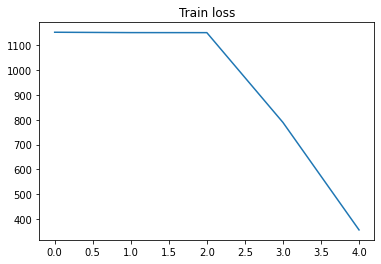

In [59]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title('Train loss')
plt.show()

In [66]:
preds = predict(val_loader, pointer_modified)

m = nn.Softmax(dim=1)

for pred in preds:
  # print(pred)
  true_array = torch.zeros(batch_size, seq_len, dtype=torch.long)
  pred_array = torch.zeros(batch_size, seq_len, dtype=torch.long)

  for logits, true in pred:
    print('True:')
    print(true)

    print('Predicted it must be in position: ')
    # print(logits)
    # print(torch.argmax(logits, dim=1))
    argmax = torch.argmax(m(logits), dim=1)
    print(argmax)

    # first build array 0, then array 1 (batch_size was 2)
    pred_array[0][argmax] = true[0]
    pred_array[1][argmax] = true[1]

    true_array[0][true[0]] = true[0]
    true_array[1][true[1]] = true[1]
  print(true_array)
  print(pred_array)
  break

C:\Users\Felipe\AppData\Local\Temp\ipykernel_2480\1698486819.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


True:
tensor([0, 0])
Predicted it must be in position: 
tensor([0, 0])
True:
tensor([1, 1])
Predicted it must be in position: 
tensor([0, 0])
True:
tensor([2, 2])
Predicted it must be in position: 
tensor([2, 2])
True:
tensor([3, 3])
Predicted it must be in position: 
tensor([3, 3])
True:
tensor([4, 4])
Predicted it must be in position: 
tensor([4, 4])
True:
tensor([5, 5])
Predicted it must be in position: 
tensor([5, 5])
True:
tensor([6, 6])
Predicted it must be in position: 
tensor([6, 6])
True:
tensor([7, 7])
Predicted it must be in position: 
tensor([7, 7])
True:
tensor([8, 8])
Predicted it must be in position: 
tensor([8, 8])
True:
tensor([9, 9])
Predicted it must be in position: 
tensor([9, 9])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
tensor([[1, 0, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 0, 2, 3, 4, 5, 6, 7, 8, 9]])
